In [130]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import year
import cartopy.crs as crs
import cartopy.feature as cfeature



# COMMAND ----------

In [131]:
spark = SparkSession.builder.getOrCreate()
df = spark.read.format('csv').option("header", True).load("cyclistic_data/csvs")
df = df.na.drop()

In [132]:
count_casual_2020 = df.where(year(df.ended_at) == 2020).where(df.member_casual == "casual").groupBy("member_casual").count()
count_members_2020 = df.where(year(df.ended_at) == 2020).where(df.member_casual == "member").groupBy("member_casual").count()
count_casual_2021 = df.where(year(df.ended_at) == 2021).where(df.member_casual == "casual").groupBy("member_casual").count()
count_members_2021 = df.where(year(df.ended_at) == 2021).where(df.member_casual == "member").groupBy("member_casual").count()
count_casual_2022 = df.where(year(df.ended_at) == 2022).where(df.member_casual == "casual").groupBy("member_casual").count()
count_members_2022 = df.where(year(df.ended_at) == 2022).where(df.member_casual == "member").groupBy("member_casual").count()
count_members_2022 = df.where(year(df.ended_at) == 2022).where(df.member_casual == "member").groupBy("member_casual").count()
count_members_all = df.where(df.member_casual == "member").groupBy("member_casual").count()
count_casual_all = df.where(df.member_casual == "casual").groupBy("member_casual").count()


['member', 'casual']


Text(0, 0.5, 'Trips')

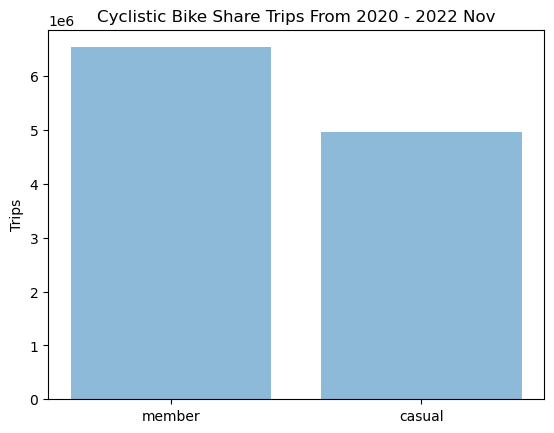

In [133]:
#  create a list of the data
data = [i[0] for i in count_members_all.select("count").collect()] + \
    [i[0] for i in count_casual_all.select("count").collect()]


#  create a list of the labels
labels = [i[0] for i in count_members_all.select("member_casual").collect()] + \
[i[0] for i in count_casual_all.select("member_casual").collect()]

print(labels)

#  create a list of the x-axis positions
x_pos = np.arange(len(labels))

#  create a bar graph of the data
plt.bar(x_pos, data, align='center', alpha=0.5)

#  add the labels to the x-axis
plt.xticks(x_pos, labels)

#  add a title to the graph
plt.title('Cyclistic Bike Share Trips From 2020 - 2022 Nov')

#  add a label to the y-axis
plt.ylabel('Trips')

[1620842, 2408628, 2507273]
[1227742, 2003303, 1726684]


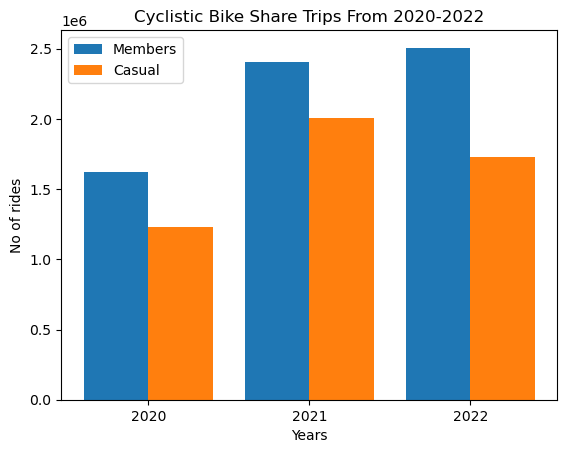

In [134]:
#  create a list of the data
members = [i[0] for i in count_members_2020.select("count").collect()] + \
    [i[0] for i in count_members_2021.select("count").collect()] + \
    [i[0] for i in count_members_2022.select("count").collect()] 


casual = [i[0] for i in count_casual_2020.select("count").collect()] + \
    [i[0] for i in count_casual_2021.select("count").collect()] + \
    [i[0] for i in count_casual_2022.select("count").collect()]

print(members)
print(casual)

X = ["2020", "2021", "2022"]

X_axis = np.arange(len(X))

#  create a bar graph of the data
plt.bar(X_axis - 0.2, members, 0.4, label="Members")
plt.bar(X_axis + 0.2, casual, 0.4, label="Casual")

#  add the labels to the x-axis
plt.xticks(X_axis, X)
plt.xlabel("Years")
plt.ylabel("No of rides")

#  add a title to the graph
plt.title('Cyclistic Bike Share Trips From 2020-2022')

plt.legend()
plt.show()


In [141]:
# distribution map
y_lim_left = 41.5848241
y_lim_right = 42.1255887
x_lim_left = -87.8902517
x_lim_right = -87.3909821
fig_size = (100,100)

In [142]:
group_by_distance_casual = df.where(df.member_casual == "casual").where(year(df.ended_at)==2020)

group_by_distance_casual.createOrReplaceTempView("table")

grouped_casual = spark.sql("""
    SELECT start_lat_sub, start_lng_sub, count(start_lat_sub) as count
    FROM (
        SELECT substr(end_lat, 1, 11) as start_lat_sub, substr(end_lng, 1, 12) as start_lng_sub
        FROM table WHERE member_casual = 'casual' 
    )
                        
    GROUP BY start_lng_sub, start_lat_sub
  
                        """
                        )


group_by_distance_member = df.where(df.member_casual == "member").where(year(df.ended_at)==2020)

group_by_distance_member.createOrReplaceTempView("table")

grouped_member = spark.sql("""
    SELECT start_lat_sub, start_lng_sub, count(start_lat_sub) as count
    FROM (
        SELECT substr(end_lat, 1, 11) as start_lat_sub, substr(end_lng, 1, 12) as start_lng_sub
        FROM table WHERE member_casual = 'member' 
    )
                        
    GROUP BY start_lng_sub, start_lat_sub
  
                        """
                        )




In [143]:
fig = plt.figure(figsize= fig_size)

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# ax.stock_img()
ax.coastlines()

ax.add_feature(cfeature.STATES)

# ax.set_extent([-90, -90, 35, 45],
#               crs=crs.PlateCarree()) ## Important

ax.set_ylim(y_lim_left, y_lim_right)
ax.set_xlim(x_lim_left, x_lim_right)



lat_casual = [float(i[0]) for i in grouped_casual.select("start_lat_sub").collect()]
lng_casual = [float(i[0]) for i in grouped_casual.select("start_lng_sub").collect()]
count_casual = [i[0] for i in grouped_casual.select("count").collect()]

lat_member = [float(i[0]) for i in grouped_member.select("start_lat_sub").collect()]
lng_member = [float(i[0]) for i in grouped_member.select("start_lng_sub").collect()]
count_member = [i[0] for i in grouped_member.select("count").collect()]

# print(lat[0], lng[0], count[0])

print(lat[:10])

plt.scatter(x=lng_casual, y=lat_casual,
            color="orangered",
            s=count_casual,
            alpha=0.6,
            transform=crs.PlateCarree()) ## Important

plt.scatter(x=lng_member, y=lat_member,
            color="green",
            s=count_member,
            alpha=0.6,
            transform=crs.PlateCarree()) ## Important

plt.show()



[41.8778183, 42.0504166, 41.8862155, 41.9407346, 41.895506, 41.8721613, 41.9245715, 41.8947413, 41.9836535, 41.965655]


In [144]:
group_by_distance_casual = df.where(df.member_casual == "casual").where(year(df.ended_at)==2021)

group_by_distance_casual.createOrReplaceTempView("table")

grouped_casual = spark.sql("""
    SELECT start_lat_sub, start_lng_sub, count(start_lat_sub) as count
    FROM (
        SELECT substr(end_lat, 1, 11) as start_lat_sub, substr(end_lng, 1, 12) as start_lng_sub
        FROM table WHERE member_casual = 'casual' 
    )
                        
    GROUP BY start_lng_sub, start_lat_sub
  
                        """
                        )

group_by_distance_member = df.where(df.member_casual == "member").where(year(df.ended_at)==2021)

group_by_distance_member.createOrReplaceTempView("table")

grouped_member = spark.sql("""
    SELECT start_lat_sub, start_lng_sub, count(start_lat_sub) as count
    FROM (
        SELECT substr(end_lat, 1, 11) as start_lat_sub, substr(end_lng, 1, 12) as start_lng_sub
        FROM table WHERE member_casual = 'member' 
    )
                        
    GROUP BY start_lng_sub, start_lat_sub
  
                        """
                        )


In [145]:
fig = plt.figure(figsize=fig_size)

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# ax.stock_img()
ax.coastlines()

ax.add_feature(cfeature.STATES)

# ax.set_extent([-90, -90, 35, 45],
#               crs=crs.PlateCarree()) ## Important

ax.set_ylim(y_lim_left, y_lim_right)
ax.set_xlim(x_lim_left, x_lim_right)



lat_casual = [float(i[0]) for i in grouped_casual.select("start_lat_sub").collect()]
lng_casual = [float(i[0]) for i in grouped_casual.select("start_lng_sub").collect()]
count_casual = [i[0] for i in grouped_casual.select("count").collect()]

lat_member = [float(i[0]) for i in grouped_member.select("start_lat_sub").collect()]
lng_member = [float(i[0]) for i in grouped_member.select("start_lng_sub").collect()]
count_member = [i[0] for i in grouped_member.select("count").collect()]

# print(lat[0], lng[0], count[0])

print(lat[:10])

plt.scatter(x=lng_casual, y=lat_casual,
            color="orangered",
            s=count_casual,
            alpha=0.6,
            transform=crs.PlateCarree()) ## Important

plt.scatter(x=lng_member, y=lat_member,
            color="green",
            s=count_member,
            alpha=0.5,
            transform=crs.PlateCarree()) ## Important

plt.show()

[41.8778183, 42.0504166, 41.8862155, 41.9407346, 41.895506, 41.8721613, 41.9245715, 41.8947413, 41.9836535, 41.965655]


In [147]:
group_by_distance_casual = df.where(df.member_casual == "casual").where(year(df.ended_at)==2022)

group_by_distance_casual.createOrReplaceTempView("table")

grouped_casual = spark.sql("""
    SELECT start_lat_sub, start_lng_sub, count(start_lat_sub) as count
    FROM (
        SELECT substr(end_lat, 1, 11) as start_lat_sub, substr(end_lng, 1, 12) as start_lng_sub
        FROM table WHERE member_casual = 'casual' 
    )
                        
    GROUP BY start_lng_sub, start_lat_sub
  
                        """
                        )


group_by_distance_member = df.where(df.member_casual == "member").where(year(df.ended_at)==2022)

group_by_distance_member.createOrReplaceTempView("table")

grouped_member = spark.sql("""
    SELECT start_lat_sub, start_lng_sub, count(start_lat_sub) as count
    FROM (
        SELECT substr(end_lat, 1, 11) as start_lat_sub, substr(end_lng, 1, 12) as start_lng_sub
        FROM table WHERE member_casual = 'member' 
    )
                        
    GROUP BY start_lng_sub, start_lat_sub
  
                        """
                        )


In [151]:
fig = plt.figure(figsize=fig_size)

ax = fig.add_subplot(1,1,1, projection=crs.PlateCarree())

# ax.stock_img()
ax.coastlines()

ax.add_feature(cfeature.STATES)

# ax.set_extent([-90, -90, 35, 45],
#               crs=crs.PlateCarree()) ## Important

ax.set_ylim(y_lim_left, y_lim_right)
ax.set_xlim(x_lim_left, x_lim_right)



lat_casual = [float(i[0]) for i in grouped_casual.select("start_lat_sub").collect()]
lng_casual = [float(i[0]) for i in grouped_casual.select("start_lng_sub").collect()]
count_casual = [i[0] for i in grouped_casual.select("count").collect()]

lat_member = [float(i[0]) for i in grouped_member.select("start_lat_sub").collect()]
lng_member = [float(i[0]) for i in grouped_member.select("start_lng_sub").collect()]
count_member = [i[0] for i in grouped_member.select("count").collect()]

# print(lat[0], lng[0], count[0])

print(lat[:10])

plt.scatter(x=lng_casual, y=lat_casual,
            color="orangered",
            s=count_casual,
            alpha=0.4,
            transform=crs.PlateCarree()) ## Important

plt.scatter(x=lng_member, y=lat_member,
            color="green",
            s=count_member,
            alpha=0.3,
            transform=crs.PlateCarree()) ## Important

plt.show()

[41.8778183, 42.0504166, 41.8862155, 41.9407346, 41.895506, 41.8721613, 41.9245715, 41.8947413, 41.9836535, 41.965655]
